I would like to compute and make a figure of the trends in krill production over the next 20 and/or 50 years. Then I would like to make a map of trend magnitude in which:
- at every grid point I compute a 20 and 50 year trend (the DJF trend)
- then compute the standard deviation of those trends across the ensemble
- then I want to compute PDFs of regional trends - specifically looking at the antarctic peninsula region
- then lastly plot the PDF of regional trends

## Set up environment

In [2]:
# set up modules
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.colors as colors
from matplotlib import style

import esmlab
import intake
import pop_tools

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Open Annual DJF Data

In [4]:
ds_djf = xr.open_zarr('data/cesm-le-fields-djf.zarr')
ds_djf

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    IFRAC      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

### Define Linear Trend Function

In [5]:
def linear_trend(da, dim='time'):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(calc_slope,
                           da_chunk,
                           vectorize=True,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')
    return trend

def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))
    
    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    if (np.sum(finite_indexes) < 2):
        slope = np.nan
    else:
        slope = np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    return slope

### Question #1: 
How do I make the function work on a dataset rather than arrays?
___
### for now....
to use the `linear_trend` function, data must be in arrays:

### Question #2: 
can I make a dataset of trend-windows? as in instead of years, the data has a coordinate of trend-windows of 5/10/20/30 years?

In [6]:
sst_5 = ds_djf['SST'].sel(time=slice('2005', '2010'))
sst_10 = ds_djf['SST'].sel(time=slice('2005', '2015'))
sst_30 = ds_djf['SST'].sel(time=slice('2005', '2035'))
sst_50 = ds_djf['SST'].sel(time=slice('2005', '2055'))

In [7]:
chl_5 = ds_djf['Chl_surf'].sel(time=slice('2005', '2010'))
chl_10 = ds_djf['Chl_surf'].sel(time=slice('2005', '2015'))
chl_30 = ds_djf['Chl_surf'].sel(time=slice('2005', '2035'))
chl_50 = ds_djf['Chl_surf'].sel(time=slice('2005', '2055'))

In [8]:
ice_5 = ds_djf['IFRAC'].sel(time=slice('2005', '2010'))
ice_10 = ds_djf['IFRAC'].sel(time=slice('2005', '2015'))
ice_30 = ds_djf['IFRAC'].sel(time=slice('2005', '2035'))
ice_50 = ds_djf['IFRAC'].sel(time=slice('2005', '2055'))

In [9]:
kgp_5 = ds_djf['KGP'].sel(time=slice('2005', '2010')).sel(length=40)
kgp_10 = ds_djf['KGP'].sel(time=slice('2005', '2015')).sel(length=40)
kgp_30 = ds_djf['KGP'].sel(time=slice('2005', '2035')).sel(length=40)
kgp_50 = ds_djf['KGP'].sel(time=slice('2005', '2055')).sel(length=40)

In [11]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(kgp_5)),
        ('2005-2015', linear_trend(kgp_10)),
        ('2005-2035', linear_trend(kgp_30)),
        ('2005-2055', linear_trend(kgp_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_kgp_trends = ds_djf_trends.compute()
ds_djf_kgp_trends

<xarray.DataArray 'KGP' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.88492637e-04,  2.03927948e-04,  2.07933692e-04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.61364025e-04,  8.35409013e-04,  8.44910589e-04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             na

In [12]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(chl_5)),
        ('2005-2015', linear_trend(chl_10)),
        ('2005-2035', linear_trend(chl_30)),
        ('2005-2055', linear_trend(chl_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_chl_trends = ds_djf_trends.compute()
ds_djf_chl_trends

<xarray.DataArray 'Chl_surf' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
   

In [13]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(sst_5)),
        ('2005-2015', linear_trend(sst_10)),
        ('2005-2035', linear_trend(sst_30)),
        ('2005-2055', linear_trend(sst_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_sst_trends = ds_djf_trends.compute()
ds_djf_sst_trends

<xarray.DataArray 'SST' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.06165147,  0.06474713,  0.06542955, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.01471555,  0.01808553,  0.02006098, ...,  0.00892244,
           0.00917988,  0.01117287],
         [ 0.01510376,  0.01870975,  0.02099818, ...,  0.00950213,
           0.00978171,  0.01158496],
         [ 0.01581957,  0.01936753,  0.02175541, ...,  0.01061174,
           0.01131222,  0.01292417]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        ...,

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]],


       [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
     

In [14]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(ice_5)),
        ('2005-2015', linear_trend(ice_10)),
        ('2005-2035', linear_trend(ice_30)),
        ('2005-2055', linear_trend(ice_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_ice_trends = ds_djf_trends.compute()
ds_djf_ice_trends

<xarray.DataArray 'IFRAC' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
      

## Plotting Trends

#### This is where things really falter... I'm not sure how to interact with the data and therefore am struggling to visualize it:

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

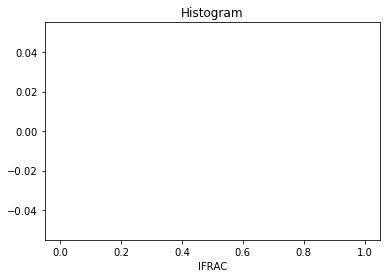

In [26]:
ds_djf_ice_trends.sel(trend = '2005-2035').plot()

In [ ]:
## Create Datafields to plot
kgp_mean = ds_djf_kgp_trends.sel(trend = '2005-2035').mean('member_id')
sst_mean = ds_djf_sst_trends.sel(trend = '2005-2035').mean('member_id')
chl_mean = ds_djf_chl_trends.sel(trend = '2005-2035').mean('member_id')
ice_mean = ds_djf_ice_trends.sel(trend = '2005-2035').mean('member_id')
lon = ds_djf_epoch.TLONG.values
lat = ds_djf_epoch.TLAT.values


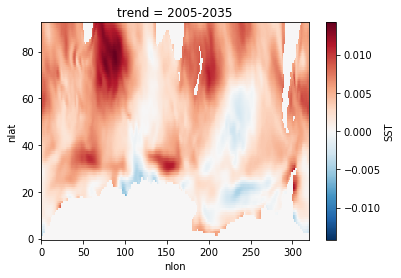

In [34]:
sst_mean.plot()

#### I then tried to use the same plotting method I've been using...
but it didn't work

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

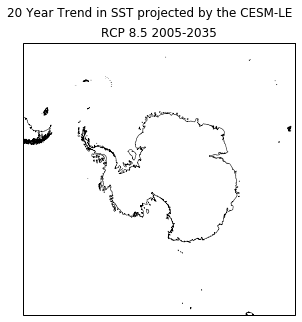

In [40]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(10,5))
fig.suptitle('20 Year Trend in SST projected by the CESM-LE')#, fontsize=)

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('RCP 8.5 2005-2035')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_mean, cmap='bwr',
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label=' SST °C')

#fig.savefig('Changes in SST RCP 85 1985-2005 vs 2070-2100', bbox_inches='tight') #,format='pdf');


In [42]:
field = sst_mean

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cf = ax.contourf(lon, lat, field,
                 cmap='bwr', 
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder

fig.colorbar(cf, ax=ax)

IllegalArgumentException: Points of LinearRing do not form a closed linestring


ValueError: GEOSGeom_createLinearRing_r returned a NULL pointer

IllegalArgumentException: Points of LinearRing do not form a closed linestring


ValueError: GEOSGeom_createLinearRing_r returned a NULL pointer

<Figure size 720x720 with 1 Axes>

___
Next I tried out some simple histograms and ran into more issues

## Probability Density Functions

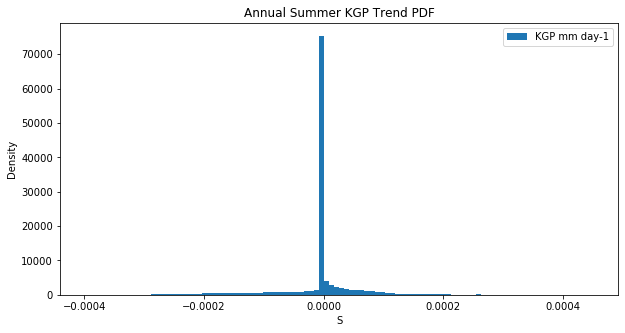

In [46]:
#Make them a vector
S_sim = kgp_mean.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_sim, 100, density=True, label='KGP mm day-1');
plt.xlabel('S')
plt.title('Annual Summer KGP Trend PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('Annual_Global-Chl_seawifs-v-cesm.png')

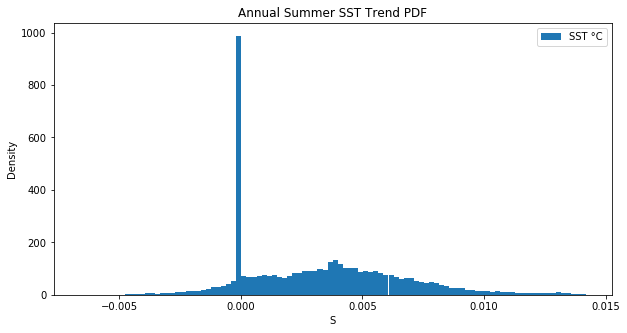

In [53]:
#Make them a vector
S_sim = sst_mean.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_sim, 100, density=True, label='SST °C');
plt.xlabel('S')
plt.title('Annual Summer SST Trend PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('Annual_Global-Chl_seawifs-v-cesm.png')

## The next two don't work and I don't understand why

ValueError: autodetected range of [nan, nan] is not finite

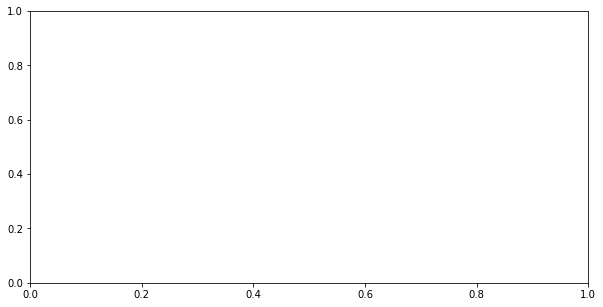

In [55]:
#Log transform the data
log_trans = np.log10(chl_mean)
#Make them a vector
S_chl = log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_chl, 100, density=True, label='Chl');
plt.xlabel('S')
plt.title('Annual Summer Chl Trend PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('Annual_Global-Chl_seawifs-v-cesm.png')

ValueError: autodetected range of [nan, nan] is not finite

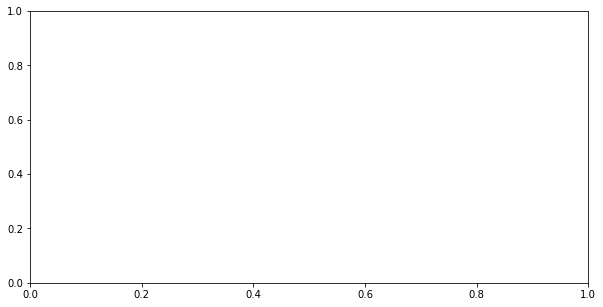

In [57]:
#Make them a vector
S_ice = ice_mean.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_ice, 100, density=True, label='KGP mm day-1');
plt.xlabel('S')
plt.title('Annual Summer KGP Trend PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('Annual_Global-Chl_seawifs-v-cesm.png')